# Script de récupération des annotions

In [17]:
import os
import numpy as np
from lxml import etree

labels = os.listdir('train/labels')
for lbl in labels:
    root = etree.parse(os.path.join('train/labels', lbl))
    objs = root.findall("object")
    bndboxes = np.zeros((len(objs), 5))
    for idx, obj in enumerate(objs):
        d = int(obj.find("difficult").text)
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        i = ymin
        j = xmin
        h = ymax - ymin
        w = xmax - xmin
        bndboxes[idx, :] = np.array([i, j, h, w, d])
    np.savetxt(os.path.join('labels_csv', lbl[:-4] + '.csv'), bndboxes, fmt='%i', delimiter=",")

In [5]:
import glob
import numpy as np
from skimage import io
import csv
import matplotlib.pyplot as plt
import os
from skimage.transform import resize

In [6]:
from skimage.feature import hog
from skimage.color import rgb2gray

# fonction permettant de récupérer tous les exemples positifs

In [20]:
for img in glob.glob("train\images\pos\*.jpg"):
    file = os.path.join('labels_csv',img[17:][:-4]+'.csv')
    if os.path.exists(file):
        csv_file = np.genfromtxt(file, delimiter=',')
        csv_file = csv_file.astype("int")
        if len(csv_file.shape) == 1 :
            csv_file = np.expand_dims(csv_file, axis = 0)
        num = 0
        for row in range(csv_file.shape[0]):
            i = csv_file[row,0]
            j = csv_file[row,1]
            h = csv_file[row,2]
            l = csv_file[row,3]
            d = csv_file[row,4]
            image = io.imread(img)
            exemple_pos = image[i:i+h+1,j:j+l+1,:]
            exemple_pos = resize(exemple_pos, (100, 50), anti_aliasing=True) 
            plt.imsave(os.path.join('train\images\pos\eco_pos',img[17:][:-4]+'_pos'+str(num)+'.jpg'), exemple_pos)
            num = num + 1

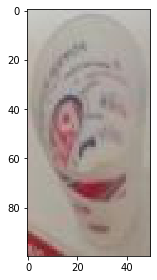

In [21]:
path = "train\images\pos\eco_pos"
img = io.imread(os.path.join(path,'amiotnoe_pos_009_pos0.jpg'))
io.imshow(img)

In [22]:
from skimage.feature import hog
from skimage.transform import resize
len(hog(resize(rgb2gray(img), (100, 50), anti_aliasing=True)))

3240

# Fonction pour récupérer des exemples positifs pivotés

In [23]:
for img in glob.glob("train\images\pos\eco_pos\*.jpg"):
    image = io.imread(img)
    imageflipr = np.fliplr(image)
    imageflipud = np.flipud(image)
    plt.imsave(os.path.join('train\images\pos\eco_pos',img[25:][:-4] + '_flipr' +'.jpg'), imageflipr)
    plt.imsave(os.path.join('train\images\pos\eco_pos',img[25:][:-4] + '_flipud' +'.jpg'), imageflipud)

# Fonction de récupération des exemples négatifs dans les photos négatives

In [24]:
import random
for img in glob.glob("train/images/neg/*.jpg"):
    image = io.imread(img)
    for ite in range(10):
        h = 1
        l = 100
        while (min(h,l)/max(h,l)) < (1/5):
            h = random.randint(20,image.shape[0]-1)
            l = random.randint(20,image.shape[1]-1)
        i = random.randint(0,image.shape[0]-1-h)
        j = random.randint(0,image.shape[1]-1-l)
        exemple_neg = image[i:i+h+1,j:j+l+1,:]
        exemple_neg = resize(exemple_neg, (100, 50), anti_aliasing=True)
        plt.imsave(os.path.join('train/images/neg/eco_neg',img[17:][:-4]+'_neg'+str(ite)+'.jpg'), exemple_neg)

In [34]:
import random
import numpy as np
from skimage import io
import csv
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
import glob

for img in glob.glob("C:/Users/user/Desktop/SY32/projet/train/images/faux_pos1/*.jpg"):
        image = io.imread(img)
        image = resize(image, (100, 50), anti_aliasing=True)
        plt.imsave(img, image)

# Fonction de fenêtre glissante forme image pour la détection

In [1]:
from skimage.filters import sobel
from skimage.color import label2rgb, rgb2gray

def texture_non_plane(img):
    '''fonction retournant si la matrice étudié est une texture plane grâce au filtre de sobel'''
    edges = sobel(rgb2gray(img))
    return (np.max(edges) > 0.2)


#la largeur et la hauteur ont été inversé ==> à échanger
def fenetre_glissante(image,clf):
    img = rgb2gray(image)
    pos_result = []
    h = (img.shape[1]+1)//8
    l = (img.shape[0]+1)//8
    for inter in range(5):
        for i in range(0,2*(img.shape[1]+1)//h):
            for j in range(0,2*(img.shape[0]+1)//l):
                coin_i = h*i//2
                coin_j = l*j//2
                fenetre = img[coin_j:(coin_j + l), coin_i:(coin_i + h)]
                fenetre1 = resize(fenetre, (50,50), anti_aliasing=True)
                I = hog(fenetre1)
                #plt.imsave(os.path.join('first_try/neg',str(inter)+str(i)+str(j)+'.jpg'), fenetre)
                if (clf.predict([I]) == 1):
                    pos_result.append([coin_j*pow(2,inter), coin_i*pow(2,inter), l*pow(2,inter), h*pow(2,inter)])
                    #plt.imsave(os.path.join('first_try/pos',str(inter)+str(i)+str(j)+'.jpg'), fenetre)
        img = resize(img, (img.shape[0]//2, img.shape[1]//2), anti_aliasing=True)
    return pos_result
#essayer avec findcontour et drawcontour

# Fenêtre glissante carrés avec incorporation du score et NMS

In [7]:
def fenetre_glissante(image,clf):
    img = rgb2gray(image)
    pos_result = []
    
    id = 0
    
    min_shape = min(img.shape[0], img.shape[1])
    c = int((min_shape+1)//8)
    
    for inter in range(4):
        
        for i in range(0,2*(img.shape[0]+1)//c):
            for j in range(0,2*(img.shape[1]+1)//c):
                coin_i = c*i//2
                coin_j = c*j//2
                fenetre = img[coin_i:(coin_i + c), coin_j:(coin_j + c)]
                fenetre1 = resize(fenetre, (50,50), anti_aliasing=True)
                I = hog(fenetre1)
                plt.imsave(os.path.join('first_try/neg',str(inter)+str(i)+str(j)+'.jpg'), fenetre)
                predict = clf.decision_function([I])
                if (predict >= 0):
                    pos_result.append([coin_i*pow(2,inter), coin_j*pow(2,inter), c*pow(2,inter),c*pow(2,inter), predict[0], id])
                    id = id + 1
                    plt.imsave(os.path.join('first_try/pos',str(inter)+str(coin_i*pow(2,inter))+str(coin_j*pow(2,inter))+'.jpg'), fenetre)
                    
        img = resize(img, (img.shape[0]//2, img.shape[1]//2), anti_aliasing=True)
    
    #le 0.5 est à discuter on pourrait faire le pari de le descendre bien plus
    pos_result = filtre_nms(pos_result, 0.5)
        
    return pos_result
#essayer avec findcontour et drawcontour

## Fonction fenêtre glissante carré avec heatmap

In [31]:
def fenetre_glissante(image,clf):
    img = rgb2gray(image)
    img_copy = img
    pos_result = []
    heat_map = HeatMap(img_copy)
    
    id = 0
    
    min_shape = min(img.shape[0], img.shape[1])
    c = int((min_shape+1)//8)
    
    for inter in range(4):
        print(inter, pow(2,inter))
        for i in range(0,2*(img.shape[0]+1)//c):
            for j in range(0,2*(img.shape[1]+1)//c):
                coin_i = c*i//2
                coin_j = c*j//2
                fenetre = img[coin_i:(coin_i + c), coin_j:(coin_j + c)]
                fenetre1 = resize(fenetre, (50,50), anti_aliasing=True)
                I = hog(fenetre1)
                predict = clf.decision_function([I])
                if (predict >= 0):
                    heat_map.add_heat([coin_i*pow(2,inter), coin_j*pow(2,inter), c*pow(2,inter),c*pow(2,inter)])
                    id = id + 1
                else:
                    pass
                    #heat_map.remove_heat([coin_i*pow(2,inter), coin_j*pow(2,inter), c*pow(2,inter),c*pow(2,inter)])
                    
        img = resize(img, (img.shape[0]//2, img.shape[1]//2), anti_aliasing=True)
    
    #on fzit ressortir les zones
    pos_result = heat_map.heat_boxes()

    for pos in pos_result:
        i = pos[0]
        j = pos[1]
        h = pos[2]
        w = pos[3]
        plt.imsave(os.path.join('first_try/pos',str(inter)+str(coin_i*pow(2,inter))+str(coin_j*pow(2,inter))+'.jpg'), img_copy[i:i+h+1, j:j+w+1])
        
    return pos_result
#essayer avec findcontour et drawcontour

## Fonction fenêtre glissante rectangulaire avec heatmap

In [89]:
def fenetre_glissante_rect(image,clf):
    print("Go")
    img = rgb2gray(image)
    img_copy = img
    pos_result = []
    heat_map = HeatMap(img_copy)
    
    id = 0
    w = 50
    h = 100
    
    for h1 in range(0,image.shape[0] - 100, 12):
        for w1 in range(0,image.shape[1] - 50, 12):
            h2 = h1 + 100
            w2 = w1 + 50
            window = img[h1:h2,w1:w2]
            plt.imsave(os.path.join('aze/az.jpg'), window)
            window = resize(window, (100,50), anti_aliasing=True)
            I = hog(window)
            predict = clf.decision_function([I])
            if (predict >= 0):
                heat_map.add_heat([h1,w1,100,50])
                id = id + 1
    #on fzit ressortir les zones
    pos_result = heat_map.heat_boxes()
    for pos in pos_result:
        i = pos[0]
        j = pos[1]
        h = pos[2]
        w = pos[3]
        plt.imsave(os.path.join('first_try/pos',str(1)+str(i*pow(2,1))+str(j*pow(2,1))+'.jpg'), img_copy[i:i+h+1, j:j+w+1])
        
    return pos_result

In [79]:
def fenetre_glissante(image,clf):
    img = rgb2gray(image)
    img_copy = img
    pos_result = []
    heat_map = HeatMap(img_copy)
    
    id = 0
    
    min_shape = min(img.shape[0], img.shape[1])
    c = int((min_shape+1)//8)
    
    for inter in range(4):
        print(inter, pow(2,inter))
        for i in range(0,2*(img.shape[0]+1)//c):
            for j in range(0,2*(img.shape[1]+1)//c):
                coin_i = c*i//2
                coin_j = c*j//2
                fenetre = img[coin_i:(coin_i + c), coin_j:(coin_j + c)]
                fenetre1 = resize(fenetre, (50,50), anti_aliasing=True)
                I = hog(fenetre1)
                predict = clf.decision_function([I])
                if (predict >= 0):
                    heat_map.add_heat([coin_i*pow(2,inter), coin_j*pow(2,inter), c*pow(2,inter),c*pow(2,inter)])
                    id = id + 1
                else:
                    pass
                    #heat_map.remove_heat([coin_i*pow(2,inter), coin_j*pow(2,inter), c*pow(2,inter),c*pow(2,inter)])
                    
        img = resize(img, (img.shape[0]//2, img.shape[1]//2), anti_aliasing=True)
    
    #on fzit ressortir les zones
    pos_result = heat_map.heat_boxes()

    for pos in pos_result:
        i = pos[0]
        j = pos[1]
        h = pos[2]
        w = pos[3]
        plt.imsave(os.path.join('first_try/pos',str(inter)+str(coin_i*pow(2,inter))+str(coin_j*pow(2,inter))+'.jpg'), img_copy[i:i+h+1, j:j+w+1])
        
    return pos_result
#essayer avec findcontour et drawcontour

# Fonction NMS

In [6]:
def filtre_nms(results_in, tresh_iou = 0.5):
    results_filtred = []
    results_out = results_in
    k1 = 0
    for result in results_in:
        max_score_indice = k1
        k2 = 0
        for subrow in results_in:
            if k2 != k1:
                recouvrement = IoU(subrow[0], subrow[1], subrow[2], subrow[3], result[0], result[1], result[2], result[3])
                if (recouvrement >= tresh_iou):
                    if subrow[4]>ref[4]:
                        del results_out[max_score_indice]
                        max_score_indice = k2
                    else :
                        del results_out[k2]
            k2 = k2 + 1
        k1 = k1 + 1
    return results_out

# Classe heatmap

In [69]:
from sklearn.preprocessing import MinMaxScaler
import cv2

class HeatMap():
    
    def __init__(self, original_image):
        self.image = np.zeros(original_image.shape[:2])
        
    def add_heat(self, coords):
        i = coords[0]
        j = coords[1]
        h = coords[2]
        w = coords[3]
        self.image[i:i+h+1,j:j+w+1] = self.image[i:i+h+1,j:j+w+1] + 30
        
    '''def remove_heat(self, coords):
        i = coords[0]
        j = coords[1]
        h = coords[2]
        w = coords[3]
        
        self.image[i:i+h+1,j:j+w+1] = self.image[i:i+h+1,j:j+w+1] - 30'''
        
    def heat_zones(self):
        scaler = MinMaxScaler()
        
        self.image = scaler.fit_transform(self.image)
        
        self.image = np.asarray(self.image * 255).astype(int)
        
        self.image = cv2.inRange(self.image,170,255)
        
        return self.image
    
    def heat_boxes(self):
        results = []
        heat_image = self.heat_zones()
        plt.imsave(os.path.join('first_try/','heat_map.jpg'), heat_image)
        contours, hierarchy = cv2.findContours(self.image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
        idx = 0
        for cnt in contours:
            j,i,w,h = cv2.boundingRect(cnt)
            results.append([i,j,h,w])

        return results

In [14]:
heatmap = HeatMap(img)

# Fonction de recherche utilisant le hog

In [115]:
def hog_glissante(img, clf):
    pos_result = []  
    h = (img.shape[0]+1)//8
    l = (img.shape[1]+1)//8
    for inter in range(5):
        hist, hog_img = hog(rgb2gray(img), visualize=True) 
        for i in range(0,2*(img.shape[0]+1)//h):
            for j in range(0,2*(img.shape[1]+1)//l):
                coin_i = h*i//2
                coin_j = l*j//2
                fenetre = hog_img[coin_i:(coin_i + h), coin_j:(coin_j + l)]
                #plt.imsave(os.path.join('first_try/neg',str(inter)+str(i)+str(j)+'.jpg'), fenetre)
                fenetre1 = resize(fenetre, (50,50), anti_aliasing=True)
                if (clf.predict([fenetre1.flatten()]) == 1):
                    pos_result.append([coin_i*(inter+1), coin_j*(inter+1), h*(inter+1), l*(inter+1)])
                    #plt.imsave(os.path.join('first_try/pos',str(inter)+str(i)+str(j)+'.jpg'), fenetre)
        img = resize(img, (img.shape[0]//2, img.shape[1]//2), anti_aliasing=True)
    return pos_result
#essayer avec findcontour et drawcontour

# Programme pour entraîner notre classifieur

In [30]:
import numpy as np
from skimage import io
import csv
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
import glob
from sklearn import svm
from skimage.feature import hog
from skimage.color import rgb2gray

X_train = np.zeros((8630,3240))
i=0
taille_doss=5670

for img in glob.glob("train/images/pos/eco_pos/*.jpg"):
    image = io.imread(img)
    I = hog(rgb2gray(image))
    X_train[i,:]=I
    i = i + 1
    
nb_pos = i
    
for img in glob.glob("train/images/neg/eco_neg/*.jpg"):
    image = io.imread(img)
    I = hog(rgb2gray(image))
    X_train[i,:]=I
    i = i + 1
    
nb_neg = i - nb_pos

y_train = np.zeros(i)

for j in range(nb_pos):
    y_train[j] = 1
    
for j in range(nb_pos, i, 1):
    y_train[j] = -1
    
print()
    
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [90]:
path = "train\images\pos"
img = io.imread(os.path.join(path,'wahartlo_pos_007.jpg'))
#h,I = hog(rgb2gray(img), visualize=True)
print(img.shape)
pos = fenetre_glissante_rect(img,clf)
print(pos)
for p in pos:
    i = p[0]
    j = p[1]
    h = p[2]
    w = p[3]
    img = cv2.rectangle(img, (j,i),(j+w,i+w), (255), 1)
#clf.predict([I.flatten()])

(2822, 2116, 3)
Go
[[2700, 2004, 65, 51], [2688, 468, 5, 15], [2664, 0, 89, 12], [2632, 1874, 9, 11], [2616, 783, 5, 9], [2592, 1440, 17, 12], [2592, 804, 17, 3], [2592, 783, 17, 9], [2568, 1980, 113, 39], [2568, 759, 41, 12], [2560, 527, 9, 17], [2556, 2064, 5, 15], [2556, 2040, 5, 3], [2556, 1992, 5, 12], [2536, 527, 9, 17], [2520, 1095, 125, 24], [2508, 1404, 5, 12], [2496, 1404, 5, 3], [2496, 291, 29, 9], [2484, 1968, 5, 3], [2484, 1932, 5, 3], [2484, 504, 5, 3], [2472, 1956, 5, 15], [2472, 1932, 5, 3], [2472, 1848, 5, 3], [2472, 1392, 17, 15], [2472, 1308, 5, 15], [2472, 1107, 29, 12], [2472, 468, 101, 24], [2448, 1128, 161, 84], [2448, 1095, 5, 24], [2428, 1343, 9, 5], [2424, 303, 29, 9], [2424, 288, 29, 12], [2400, 1848, 65, 3], [2388, 1956, 17, 3], [2388, 1860, 5, 3], [2376, 1308, 125, 72], [2376, 1047, 5, 9], [2376, 1035, 5, 9], [2364, 1908, 5, 3], [2364, 1860, 5, 3], [2352, 1908, 5, 3], [2344, 470, 9, 23], [2340, 552, 5, 15], [2332, 995, 9, 5], [2328, 552, 5, 15], [2316, 1908

In [61]:
clf.predict(hog(rgb2gray(io.imread("train/images/pos/eco_pos/amagnero_pos_001_pos0_flipr_flipr.jpg"))))

ValueError: Expected 2D array, got 1D array instead:
array=[0.17609875 0.23298514 0.27868152 ... 0.02913939 0.03498776 0.032374  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# Fonction de recouvrement

In [5]:
def IoU(i1,j1,h1,l1,i2,j2,h2,l2):
    hgi = max(i1,i2)
    hgj = max(j1,j2)
    
    hdj = min(j1+l1, j2+l2)
    
    bgi = min(i1+h1, i2+h2)
    
    aire1 = h1*l1
    aire2 = h2*l2
    
    if ((hdj-hgj)<=0) or ((bgi-hgi)<=0):
        airec = 0
    else :
        airec = (hdj-hgj)*(bgi-hgi)
    
    return(airec/(aire1+aire2-airec))

# Fonction récupérant les faux positifs du premier classifieur

In [43]:
result_pos = []
faux_pos = []

for img in glob.glob("train/images/pos/*.jpg"):
    if os.path.exists(os.path.join('labels_csv',img[17:][:-4]+'.csv')) == True:
        image = io.imread(img)
        result_pos = fenetre_glissante(image,clf)
        label = np.genfromtxt(os.path.join("C:/Users/user/Desktop/SY32/projet/labels_csv",img[17:][:-4]+'.csv'), delimiter=",")
        label = label.astype("int")

        if len(label.shape) == 1:
            label = np.expand_dims(label, axis=0)

        faux_pos_counter = 0

        for pos in result_pos:
            flag_pos = 0
            for subrow in label :
                recouvrement = IoU(subrow[0], subrow[1], subrow[2], subrow[3], pos[0], pos[1], pos[2], pos[3])
                #if (recouvrement >= 0.5):
                if (recouvrement >= 0.3):
                    flag_pos = 1
            if (flag_pos==0):
                copy_pos = image[pos[0]:(pos[0]+pos[2]), pos[1]:(pos[1]+pos[3])]
                copy_pos = resize(copy_pos, (50, 50), anti_aliasing=True)
                plt.imsave(os.path.join('train/images/faux_pos2/',img[17:][:-4] +'_faux_pos_'+ str(faux_pos_counter) +'.jpg'), copy_pos)
